# Play with keras model

In [1]:
%pylab inline
import numpy as np
import csv
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from sklearn import metrics
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler
from sklearn import utils
from preprocess import loadPreData
from preprocess import scoreAUC
subm_folder = './submissions'
'''
    This demonstrates how to reach a 0.80 ROC AUC score (local 4-fold validation)
    in the Kaggle Nile virus prediction challenge. 

    The model trains in a few seconds on CPU.
'''

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.
//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


'\n    This demonstrates how to reach a 0.80 ROC AUC score (local 4-fold validation)\n    in the Kaggle Nile virus prediction challenge. \n\n    The model trains in a few seconds on CPU.\n'

In [2]:
data = loadPreData(features=True)

Index([u'Address', u'Species', u'Block', u'Street', u'Trap',
       u'AddressNumberAndStreet', u'Latitude', u'Longitude',
       u'AddressAccuracy', u'NumMosquitos', u'WnvPresent'],
      dtype='object')
Index([u'Id', u'Address', u'Species', u'Block', u'Street', u'Trap',
       u'AddressNumberAndStreet', u'Latitude', u'Longitude',
       u'AddressAccuracy'],
      dtype='object')


In [33]:
X = data['train'].get_values().astype(float)
y = data['labels']
Y = np_utils.to_categorical(y)

In [4]:
input_dim = X.shape[1]
output_dim = 2

In [37]:
def build_model(input_dim, output_dim):
    model = Sequential()
    model.add(Dense(32, input_dim=input_dim, kernel_initializer='random_uniform'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(32, kernel_initializer='random_uniform'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(32, kernel_initializer='random_uniform'))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(output_dim, kernel_initializer='random_uniform'))

    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return model

In [8]:
def testModel():    
    def logit(x):
        return 1/(1+np.exp(-x))

    X = (np.random.rand(5000,5))
    covs = np.tile(100.*(1.-2.*np.random.rand(5)),(5000,1))
    y = np.sum(X*covs,axis=1)

    y =  (logit(y)>0.5).astype(float)
    print y.shape
    y = np_utils.to_categorical(y)
    
    X_valid = np.random.rand(1000,5)
    
    y_valid = np.sum(covs[:1000,:]*X_valid,axis=1)
    y_valid =  (logit(y_valid)>0.5).astype(float)
    y_valid = np_utils.to_categorical(y_valid)
    
    model = build_model(5, 2)
    print 'Data input shape {}, data output shape {}'.format(X.shape,y.shape)
    model.fit(X, y, nb_epoch=10, batch_size=32, validation_data=(X_valid, y_valid), verbose=True)
    return {'model':model,'X_valid':X_valid,'y_valid':y_valid,'X_train':X,'y_train':y}

In [9]:
res = testModel()

(5000,)
Data input shape (5000, 5), data output shape (5000, 2)
Train on 5000 samples, validate on 1000 samples
Epoch 1/10
5000/5000 [==============================] - 0s - loss: 0.5671 - acc: 0.6982 - val_loss: 0.3011 - val_acc: 0.8710
Epoch 2/10
5000/5000 [==============================] - 0s - loss: 0.2119 - acc: 0.9352 - val_loss: 0.1000 - val_acc: 0.9950
Epoch 3/10
5000/5000 [==============================] - 0s - loss: 0.1183 - acc: 0.9616 - val_loss: 0.0613 - val_acc: 0.9940
Epoch 4/10
5000/5000 [==============================] - 0s - loss: 0.0787 - acc: 0.9754 - val_loss: 0.0470 - val_acc: 0.9900
Epoch 5/10
5000/5000 [==============================] - 0s - loss: 0.0648 - acc: 0.9778 - val_loss: 0.0394 - val_acc: 0.9890
Epoch 6/10
5000/5000 [==============================] - 0s - loss: 0.0587 - acc: 0.9780 - val_loss: 0.0379 - val_acc: 0.9820
Epoch 7/10
5000/5000 [==============================] - 0s - loss: 0.0488 - acc: 0.9822 - val_loss: 0.0358 - val_acc: 0.9870
Epoch 8/10
50

  32/1000 [..............................] - ETA: 0s

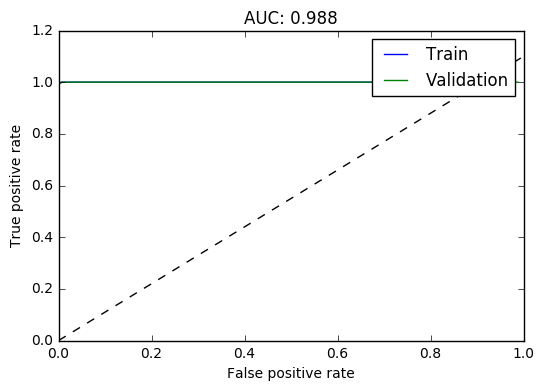

In [31]:
model = res['model']
X_train,X_test = res['X_train'],res['X_valid']
y_train,y_test = res['y_train'],res['y_valid']
y_train,y_test = y_train[:,1].astype(bool),y_test[:,1].astype(bool)
probs = model.predict_proba(X_train)
auc = scoreAUC(y_train,probs)
plt.plot(auc['fpr'],auc['tpr'],label='Train');

probs = model.predict_proba(X_test)
auc = scoreAUC(y_test,probs)
plt.plot(auc['fpr'],auc['tpr'],label='Validation');

plt.legend();

plt.plot([0,1.],[0,1.1],'k--');
plt.xlabel('False positive rate');
plt.ylabel('True positive rate');


plt.title('AUC: {:.3f}'.format(auc['score']));

In [9]:
#class_weight = {0 : 1.,1: 50.}

nb_folds = 4
kfolds = KFold(len(y), nb_folds)
av_roc = 0.
f = 0
for train, valid in kfolds:
    print('---'*20)
    print('Fold', f)
    print('---'*20)
    f += 1
    X_train = X[train]
    X_valid = X[valid]
    Y_train = Y[train]
    Y_valid = Y[valid]
    y_valid = y[valid]
    print("fold has {} WNV present".format(np.sum(Y_train[:,1])))
    class_weight = utils.class_weight.compute_class_weight('balanced', np.unique(y[train]), y[train])
    print("Class weight: {}".format(class_weight))
    print("Building model...")
    model = build_model(input_dim, output_dim)

    print("Training model...")

    model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_valid, Y_valid), 
              class_weight=class_weight,verbose=True)
    valid_preds = model.predict_proba(X_valid)
    valid_preds = valid_preds[:, 1]
    roc = metrics.roc_auc_score(y_valid, valid_preds)
    print("ROC:", roc)
    av_roc += roc

print('Average ROC:', av_roc/nb_folds)

------------------------------------------------------------
('Fold', 0)
------------------------------------------------------------
fold has 366.0 WNV present
Class weight: [  0.52435778  10.7636612 ]
Building model...
Training model...
Train on 7879 samples, validate on 2627 samples
Epoch 1/20
7879/7879 [==============================] - 1s - loss: 0.2530 - acc: 0.9461 - val_loss: 0.2525 - val_acc: 0.9296
Epoch 2/20
7879/7879 [==============================] - 0s - loss: 0.2154 - acc: 0.9535 - val_loss: 0.2528 - val_acc: 0.9296
Epoch 3/20
7879/7879 [==============================] - 0s - loss: 0.2041 - acc: 0.9535 - val_loss: 0.2610 - val_acc: 0.9296
Epoch 4/20
7879/7879 [==============================] - 0s - loss: 0.2035 - acc: 0.9535 - val_loss: 0.2632 - val_acc: 0.9296
Epoch 5/20
7879/7879 [==============================] - 0s - loss: 0.1943 - acc: 0.9535 - val_loss: 0.2814 - val_acc: 0.9296
Epoch 6/20
7879/7879 [==============================] - 0s - loss: 0.1974 - acc: 0.9535 

In [10]:
np.sum(model.predict_proba(X_valid)[:,1])

1888/2626 [====================>.........] - ETA: 0s

101.35306

In [38]:
class_weight = utils.class_weight.compute_class_weight('balanced', np.unique(y), y)
Y = np_utils.to_categorical(y)
model = build_model(input_dim, output_dim)
model.fit(X, Y, nb_epoch=20, batch_size=32, verbose=1,class_weight=class_weight)

Epoch 1/20
10506/10506 [==============================] - 1s - loss: 0.2552 - acc: 0.9446     
Epoch 2/20
10506/10506 [==============================] - 1s - loss: 0.2316 - acc: 0.9476     
Epoch 3/20
10506/10506 [==============================] - 1s - loss: 0.2163 - acc: 0.9476     
Epoch 4/20
10506/10506 [==============================] - 1s - loss: 0.2130 - acc: 0.9476     
Epoch 5/20
10506/10506 [==============================] - 1s - loss: 0.2071 - acc: 0.9476     
Epoch 6/20
10506/10506 [==============================] - 1s - loss: 0.2047 - acc: 0.9476     
Epoch 7/20
10506/10506 [==============================] - 1s - loss: 0.2041 - acc: 0.9476     
Epoch 8/20
10506/10506 [==============================] - 1s - loss: 0.2034 - acc: 0.9476     
Epoch 9/20
10506/10506 [==============================] - 1s - loss: 0.1992 - acc: 0.9476     
Epoch 10/20
10506/10506 [==============================] - 1s - loss: 0.1980 - acc: 0.9476     
Epoch 11/20
10506/10506 [========================

 9600/10506 [==========================>...] - ETA: 0s

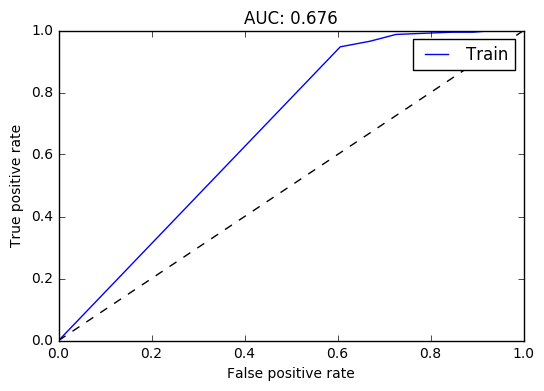

In [39]:
probs = model.predict_proba(X)
auc = scoreAUC(y,probs)
plt.plot(auc['fpr'],auc['tpr'],label='Train');




plt.legend();

plt.plot([0,1.],[0,1.],'k--');
plt.xlabel('False positive rate');
plt.ylabel('True positive rate');


plt.title('AUC: {:.3f}'.format(auc['score']));

In [12]:
X_sub = data['test'].get_values()

In [13]:
subs = model.predict_proba(X_sub)


115968/116293 [============================>.] - ETA: 0s

array([ 0.93258017,  0.93265349,  0.93250686, ...,  0.9411791 ,
        0.94191837,  0.93935519], dtype=float32)

In [14]:
np.sum(data['labels']==1)/float(data['labels'].size)

0.052446221206929371

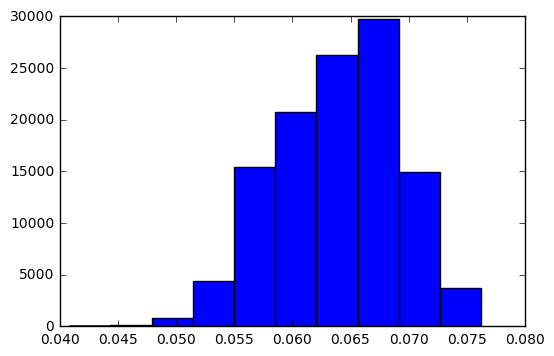

In [18]:
plt.hist(subs[:,1]);

In [23]:
#prepare submission
import pandas as pd
import os.path
ss = pd.DataFrame(columns=['Id','WnvPresent'])
ss['WnvPresent'] = pd.Series(subs[:,1])
ss['Id'] = data['test'].index + 1
ss.to_csv(os.path.join(subm_folder, 'keras_submission_1.csv'), index=False)

gives a score of around 0.55